 # Статистический анализ данных и проверка гипотез. 
 В нашем распоряжении данные о некоторых пользовательях их нескольки городов популярного сервиса аренды самокатов GoFAst. 
 
Сервисом можно пользоваться:
 - без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
 - с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
Нам предоставленны следующие данные: 
- Пользователи — `user_id`, `name`, `age`, `city`, `subscription_type`
- Поездки —  `user_id`, `distance`, `duration`, `date`
- Подписки —  `subscription_type`, `minute_price`, `start_ride_price`, `subscription_fee`

Ход работы: 
1. Обзор данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Объединение данных;
5. Подсчет выручки;
5. Проверка гипотез.



## Обзор данных

In [1]:
# импорт библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import factorial

In [2]:
# читаем файлы
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод**

Ознакомились со всеми таблицами и обнаружили минимальные погрешности. Например, данные в столбце 'date' таблицы поездок сохранены как object, что не является оптимальным. На этапе предобработки будем работать с дубликатами и пропусками, а также исправим ошибку в типе данных столбца 'date'.

## Предобработка данных
* Приведем столбец date к типу даты pandas.
* Создадим новый столбец с номером месяца на основе столбца date.
* Проверим наличие пропущенных значений и дубликатов в датафреймах. 

### Приведем столбец `date` к типу даты

In [6]:
# приведем данные к типу datetime
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')

### Создадим новый столбец с номером месяца на основе столбца 'date'.

In [7]:
# добавим столбец с номерами месяца 
rides['month'] = rides['date'].dt.month

### Проверим на наличие пропусков и дубликатов

In [8]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Пропусков нет. Скорее всего данные в метрах, по этому для удобства перезапишем их в км. и огрулим до 2х значения после точки.

In [9]:
rides['distance'] = (rides['distance'] / 1000).round(2)

То же самое можно сделать и со столбцом 'duration'. Округлим до 2х значений после точки. 

In [10]:
rides['duration'] = rides['duration'].round(2)
rides.head()

,user_id,distance,duration,date,month
0,1,4.41,25.60,2021-01-01,1
1,1,2.62,15.82,2021-01-18,1
2,1,0.75,6.23,2021-04-20,4
3,1,2.69,18.51,2021-08-11,8
4,1,4.03,26.27,2021-08-28,8


In [11]:
rides.duration.describe()

count    18068.000000
mean        17.805017
std          6.091071
min          0.500000
25%         13.600000
50%         17.680000
75%         21.722500
max         40.820000
Name: duration, dtype: float64

Видны поездки меньше минуты.

In [12]:
# проверим сколько поездок меньше минуты, если мало, можем избавится от них
len(rides.loc[rides['duration'] < 1])

95

In [13]:
# удаляем эти значения из стобца 
rides.drop(rides.loc[rides['duration'] < 1].index, inplace=True)
rides = rides.reset_index(drop=True) #сбрасываем индексы

Проспусков в датафреймах не выявлено. 

In [14]:
# проверим наличие дубликатов в столбце пользователей
users.user_id.duplicated().sum()

31

In [15]:
# удалим дубликаты 
users = users.drop_duplicates()
users = users.reset_index(drop=True)

**Вывод**

- Преобразовал данные в столбце 'date' в формат даты.
- Добавил столбец с месяцем поездки.
- Преобразовал данные в столбцах с расстоянием и продолжительностью поездок в удобный и читабельный формат.

## Исследовательский анализ данных

Визуализируем общую информацию о пользователях и поездках:
* частота встречаемости городов;
* соотношение пользователей с подпиской и без подписки;
* возраст пользователей;
* расстояние, которое пользователь преодолел за одну поездку;
* продолжительность поездок.

### Частота встречаемости поездок
Покажем общую информацию о пользователях и поездках на графике. 

In [16]:
table = users['city'].value_counts()
table

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

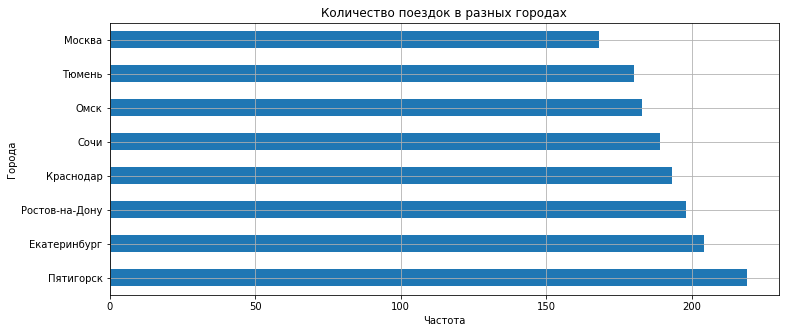

In [17]:
# создаем график 
table.plot(kind='barh', figsize=(12, 5))
plt.title('Количество поездок в разных городах')
plt.xlabel('Частота')
plt.ylabel('Города')
plt.grid(True)
plt.show()

Несмотря на то, что Москва имеет большую популяцию, данные показывают, что в Москве использование самокатов меньше по сравнению с другими городами. Однако, в Пятигорске наблюдается наибольшее количество поездок на самокатах.

### Соотношение пользователей с подпиской и без подписки 

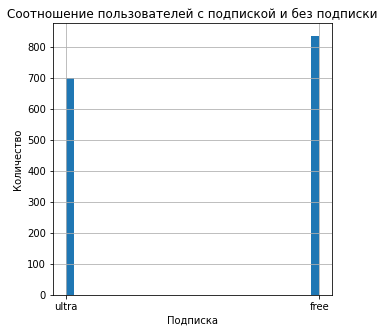

In [18]:
# соотношение пользователей с подпиской и без
users['subscription_type'].hist(bins=30, figsize=(5, 5))
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Подписка')
plt.ylabel('Количество')
plt.show()

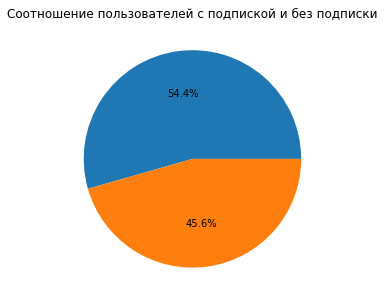

In [19]:
su = users['subscription_type'].value_counts()

# создаем график 
plt.figure(figsize=(5, 5))
plt.pie(su, autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Синим цветом отображены пользователи без подписки, а оранжевым - **ultra**.

Пользователей без подписки больше.

### Возраст пользователей

In [20]:
# посмотим статистическую информацию столбца age
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

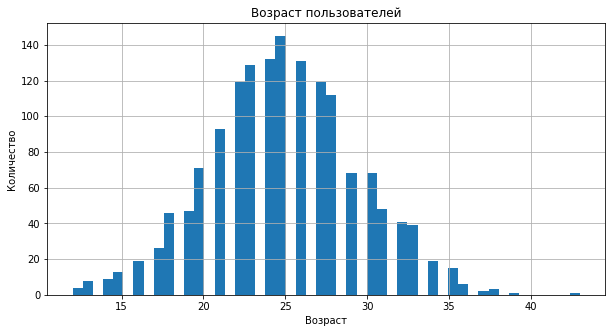

In [21]:
# создаем график 
users['age'].hist(bins=50, figsize=(10, 5))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

В целом, как можно было догадаться, самокатами пользуется молодежь (в РФ молодежь - от 14 до 35 лет включительно).
В основном самокатами пользуются люди в возрасте от 22 до 28 лет. Но больше всех выделяются пользователи в возрасте 24 лет.

### Растояние, которое преодолевают пользователи за одну поездку

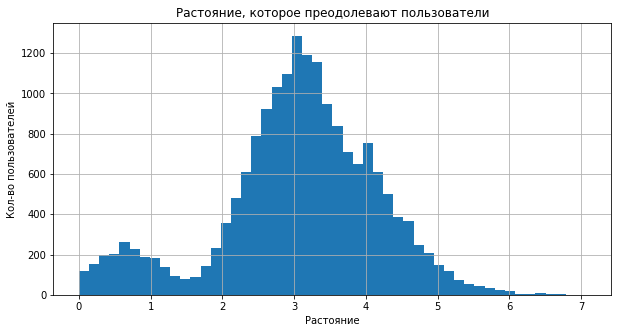

In [22]:
# создаем график
rides['distance'].hist(bins=50, figsize=(10, 5))
plt.title('Растояние, которое преодолевают пользователи')
plt.xlabel('Растояние')
plt.ylabel('Кол-во пользователей')
plt.show()

Большинство людей преодолевают на самокате примерно 2-4 километра. Предположу, что это связано с прогулками, поездками от или до дома/работы/школы.

Но выделяется расстояние 1,5 километра. Наверняка это обусловлено поездками до ближайшей станции метро или остановки.

### Продолжительность поездки 

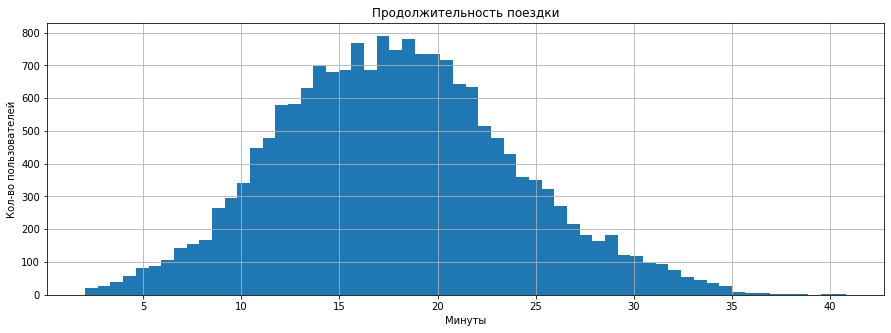

In [23]:
# создаем график
rides['duration'].hist(bins=60, figsize=(15, 5))
plt.title('Продолжительность поездки')
plt.xlabel('Минуты')
plt.ylabel('Кол-во пользователей')
plt.show()

Если средняя скорость самокатов установлена в пределах 15-18 км/ч, то все сходится. (Скорость = Расстояние / Время)

**Вывод**

В основном молодежь пользуется самокатами, которые преодолевают расстояние от 2 до 4 км за 10-25 минут.
Стоит также отметить, что количество поездок без подписки больше.

Удивительно также соотношение городов. Например, в Москве (население 13 млн) количество пользователей меньше, чем в Пятигорске (145 тысяч). Предполагаю, что это связано с соотношением самокатов и пользователей.

## Объединение данных

* Объединим данные о пользователях, поездках и подписках в один датафрейм методом merge().
* Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
    * c данными о пользователях без подписки;
    * с данными о пользователях с подпиской.
* Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

### Объеденим данные о пользователях, поездках и подписаках в один датафрейм

In [24]:
# объединим таблицы пользователей, поездок и подписках
df = users.merge(rides, on='user_id', how='outer') 
df = df.merge(subs, on='subscription_type', how='outer')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4.41,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2.62,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,0.75,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2.69,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4.03,26.27,2021-08-28,8,6,0,199


### Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1
* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

In [25]:
# создадим таблицу пользователей с подпиской
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra.info() 
df_ultra.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4.41,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2.62,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,0.75,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2.69,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4.03,26.27,2021-08-28,8,6,0,199


In [26]:
# создадим таблицу пользователей без подписки 
df_free = df[df['subscription_type'] == 'free']
df_free.info() 
df_free.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   name               11473 non-null  object        
 2   age                11473 non-null  int64         
 3   city               11473 non-null  object        
 4   subscription_type  11473 non-null  object        
 5   distance           11473 non-null  float64       
 6   duration           11473 non-null  float64       
 7   date               11473 non-null  datetime64[ns]
 8   month              11473 non-null  int64         
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2.52,14.94,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,0.85,16.23,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4.00,20.02,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1.21,9.78,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3.05,17.43,2021-02-14,2,8,50,0


### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

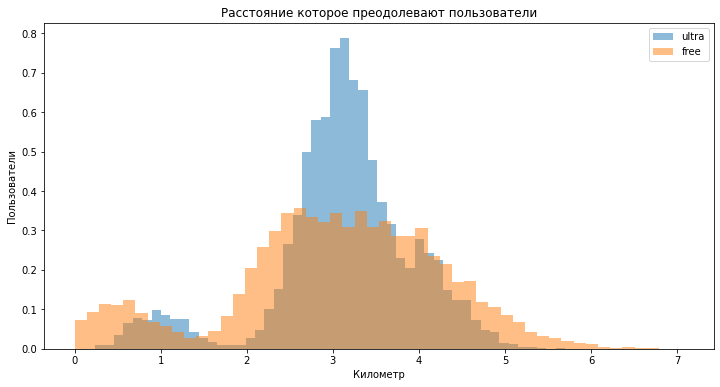

In [27]:
# создаем график 
plt.figure(figsize=(12, 6))
plt.hist(df_ultra.distance, label='ultra', bins=50, alpha=0.5, density=True)
plt.hist(df_free.distance, label='free', bins=50, alpha=0.5, density=True)
plt.xlabel('Километр')
plt.ylabel('Пользователи')
plt.title('Расстояние которое преодолевают пользователи')
plt.legend()
plt.show()

Пользователи с подпиской в среднем преодолевают чуть больше 3 км. Пользователи без подписки в среднем проезжают столько же, но их в 2 раза меньше, чем пользователей с подпиской.

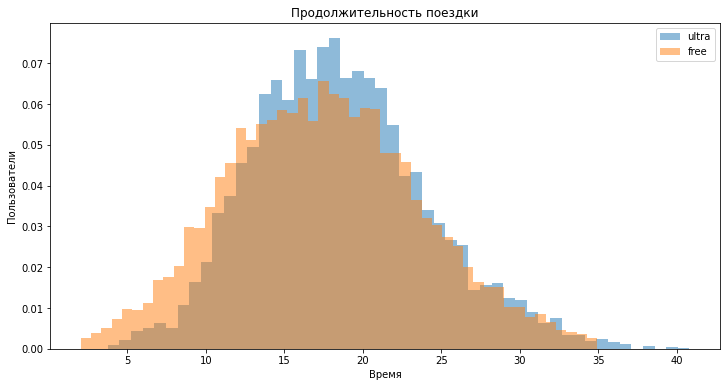

In [28]:
# создаем график 
plt.figure(figsize=(12, 6))
plt.hist(df_ultra.duration, label='ultra', bins=50, alpha=0.5, density=True)
plt.hist(df_free.duration, label='free', bins=50, alpha=0.5, density=True)
plt.xlabel('Время')
plt.ylabel('Пользователи')
plt.title('Продолжительность поездки')
plt.legend()
plt.show()

Тратят на поездки так же одинаковое кол-во времени, но опять таки, **ultra** подписчики по количеству поездок больше.

**Вывод**

Можно сказать, что пользователи с подпиской преодолевают в среднем чуть больше 3 км. Пользователи без подписки преодолевают в среднем столько же, но их количество в 2 раза меньше, чем пользователей с подпиской.

## Подсчёт выручки
* Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
* В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляем до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

Для начала округлим продолжительность поездки.

In [29]:
df['duration'] = np.ceil(df['duration'])

Создаем датафрейм с агрегированными данными на основе **df**. Найдем сумарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [30]:
agg_df = df.groupby(['user_id', 'month', 'subscription_type', 'start_ride_price', 
                     'minute_price', 'subscription_fee']).agg({'distance': 'sum', 
                                                               'duration': ['count', 'sum']})
agg_df.columns = ['distance_sum', 'duration_count', 'duration_sum']
agg_df = agg_df.reset_index()
agg_df.head()

,user_id,month,subscription_type,start_ride_price,minute_price,subscription_fee,distance_sum,duration_count,duration_sum
0,1,1,ultra,0,6,199,7.03,2,42.0
1,1,4,ultra,0,6,199,0.75,1,7.0
2,1,8,ultra,0,6,199,6.72,2,46.0
3,1,10,ultra,0,6,199,5.81,2,32.0
4,1,11,ultra,0,6,199,7.00,3,56.0


Теперь у нас есть таблица с сумарным расстоянием, кол-вом поездок и суммарным временем для каждого пользвателя за каждый месяц.

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [31]:
agg_df['month_income'] = agg_df['start_ride_price'] * agg_df['duration_count']\
+ agg_df['minute_price'] * agg_df['duration_sum'] + agg_df['subscription_fee'] 
agg_df.head()

,user_id,month,subscription_type,start_ride_price,minute_price,subscription_fee,distance_sum,duration_count,duration_sum,month_income
0,1,1,ultra,0,6,199,7.03,2,42.0,451.0
1,1,4,ultra,0,6,199,0.75,1,7.0,241.0
2,1,8,ultra,0,6,199,6.72,2,46.0,475.0
3,1,10,ultra,0,6,199,5.81,2,32.0,391.0
4,1,11,ultra,0,6,199,7.00,3,56.0,535.0


**Вывод**

Итак, у нас теперь есть отдельный датафрейм с с ежемесячной выручкой от каждой поездки каждого пользователья самокатов.

## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
* Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
* Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделайте выводы.
* Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.
* Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Проверим первую гипотезу.

- H0 - Среднее время поездки у пользователей с подпиской и без подписки одинаковое 
- H1 - Среднее время поездки у пользователей с подпиской больше чем у пользователей без подписки.

Если больше с подпиской то это "выгоднее" для компании. 


Для проверки данной гипотезы можно воспользоваться методом двусторонней гипотезы (t-тестом) для независимых выборок. В данном случаем можем сравнить среднюю продолжительность поездок для пользователей с подпиской и для пользователей без подписки. 

Если p-value будет меньше выбранного уровня значимости alpha = 0.05, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [32]:
alpha = 0.05
results = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.68327274119323e-28
Отвергаем нулевую гипотезу


Проверим средние значения продолжительности поездок для каждой категории пользователей.

In [33]:
df_ultra['duration'].mean()

18.542016923076922

In [34]:
df_free['duration'].mean()

17.53076178854702

Средняя продолжительность поездок у пользователей с подпиской и без - не совпадают!

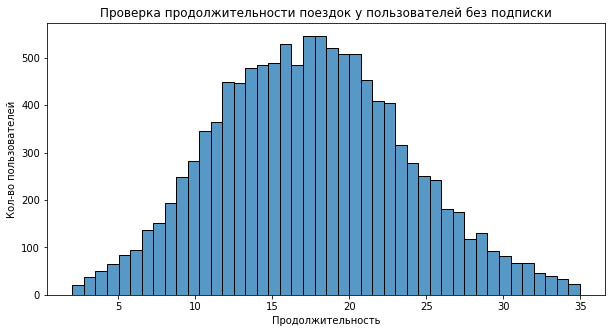

In [35]:
# создаем график 
plt.subplots(figsize=(10, 5))
sns.histplot(df_free['duration'])
plt.title('Проверка продолжительности поездок у пользователей без подписки')
plt.xlabel('Продолжительность')
plt.ylabel('Кол-во пользователей')
plt.show()

**Вывод**

р-значение меньше альфа - мы можем отвергнуть нулевую гипотезу о равенстве средних продолжительностей поездок и сделать вывод, что пользователи с подпиской и без подписки имеют различные средние значения продолжительности поездок.



Проверим вторую гипотезу
* H0 - Среднее расстояние, которое проезжает пользователь с подпиской за одну поездку, не превышает 3130 метров.
* H1 - Среднее расстояние, которое проезжает пользователь с подпиской за одну поездку, превышает 3130 метров.

Для проверки данной гипотезы можно воспользоваться одновыборочным t-тестом. Мы можем сравнить среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, с определенным значением (в данном случае 3130 метров).


In [36]:
alpha = 0.05
results = st.ttest_1samp(df_ultra['distance'], 3.13, alternative='greater')

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.9199218607432119
Не получилось отвергнуть нулевую гипотезу


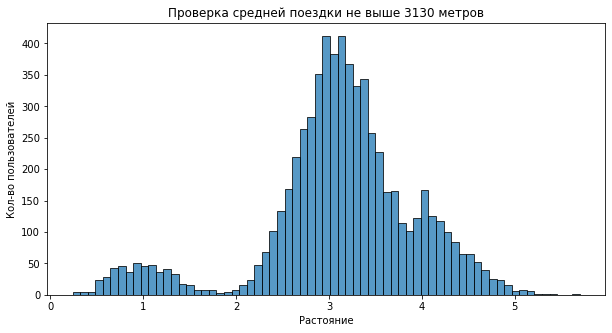

In [37]:
# создаем график 
plt.subplots(figsize=(10, 5))
sns.histplot(df_ultra['distance'])
plt.title('Проверка средней поездки не выше 3130 метров')
plt.xlabel('Растояние')
plt.ylabel('Кол-во пользователей')
plt.show()

**Вывод**

p-значение больше альфа - мы не можем отвергнуть нулевую гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Таким образом, нет оснований сделать вывод о том, что среднее расстояние превышает указанное значение.

Проверим третью гипотезу

- H0 - Месячная выручка от пользователей с подпиской и без подписки одинаковые
- H1 - Месячная выручка от пользователей с подпиской больше чем у пользователей без подпискиски

Тут тоже воспользумеся методом двусторонней гипотезы (t-тестом). 

In [38]:
agg_df_ultra = agg_df[agg_df['subscription_type'] == 'ultra'] 
agg_df_free = agg_df[agg_df['subscription_type'] == 'free']

alpha = 0.05
results = st.ttest_ind(
    agg_df_ultra.loc[:,'month_income'],
    agg_df_free.loc[:,'month_income'], alternative='greater')

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.957394033609321e-30
Отвергаем нулевую гипотезу


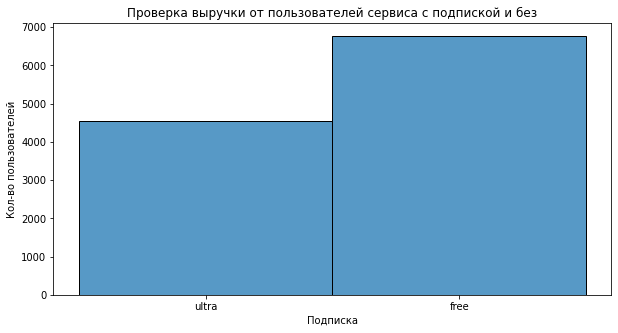

In [39]:
# создаем график 
plt.subplots(figsize=(10, 5))
sns.histplot(agg_df['subscription_type'])
plt.title('Проверка выручки от пользователей сервиса с подпиской и без')
plt.xlabel('Подписка')
plt.ylabel('Кол-во пользователей')
plt.show()

Помсотрим на средние значения выручки для каждой категории пользователей.

In [40]:
agg_df_ultra.describe()

,user_id,month,start_ride_price,minute_price,subscription_fee,distance_sum,duration_count,duration_sum,month_income
count,4533.000000,4533.000000,4533.0,4533.0,4533.0,4533.000000,4533.000000,4533.000000,4533.000000
mean,347.769910,6.427973,0.0,6.0,199.0,4.467289,1.433929,27.287668,362.726009
std,200.433553,3.418698,0.0,0.0,0.0,2.353305,0.696331,14.706956,88.241734
min,1.000000,1.000000,0.0,6.0,199.0,0.240000,1.000000,4.000000,223.000000
25%,174.000000,3.000000,0.0,6.0,199.0,2.980000,1.000000,17.000000,301.000000
50%,348.000000,6.000000,0.0,6.0,199.0,3.570000,1.000000,22.000000,331.000000
75%,523.000000,9.000000,0.0,6.0,199.0,5.890000,2.000000,35.000000,409.000000
max,699.000000,12.000000,0.0,6.0,199.0,20.010000,6.000000,126.000000,955.000000


In [41]:
agg_df_free.describe()

,user_id,month,start_ride_price,minute_price,subscription_fee,distance_sum,duration_count,duration_sum,month_income
count,6767.000000,6767.000000,6767.0,6767.0,6767.0,6767.000000,6767.000000,6767.000000,6767.000000
mean,1120.077878,6.513522,50.0,8.0,0.0,5.134401,1.695434,30.561844,329.266440
std,240.453527,3.457707,0.0,0.0,0.0,3.161801,0.889829,17.798731,183.215022
min,700.000000,1.000000,50.0,8.0,0.0,0.000000,1.000000,3.000000,74.000000
25%,915.000000,4.000000,50.0,8.0,0.0,2.930000,1.000000,18.000000,194.000000
50%,1120.000000,7.000000,50.0,8.0,0.0,4.290000,1.000000,26.000000,274.000000
75%,1326.000000,9.000000,50.0,8.0,0.0,6.795000,2.000000,40.000000,428.000000
max,1534.000000,12.000000,50.0,8.0,0.0,23.430000,7.000000,143.000000,1444.000000


Действительно, в среднем ежемесячный доход от пользователей с подпиской чуть выше, чем от пользователей без подписки. Однако, общая выручка от пользователей без подписки превышает выручку от пользователей с подпиской. Это связано с тем, что у сервиса больше пользователей без подписки.

**Вывод**

р-значение меньше alpha - можем отвергнуть нулевую гипотезу о равенстве средних выручек и сделать вывод, что помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

**Вопрос** - Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

*Ответ - Для проверки гипотезы о том, что обновление серверов значимо снизило количество обращений в техподдержку, можно использовать парный t-тест для зависимых выборок. Парный t-тест позволяет сравнить различия между двумя связанными выборками. Из библиотеки scipy.stats для проведения t-теста мы можете использовать функцию ttest_rel.*

## Общий вывод

Мы изучили выборку данных сервиса аренды самокатов. Основная задача - выявить, от кого получается больше дохода: от пользователей с подпиской или без подписки.

Выяснили:
* В основном молодежь пользуется самокатами, которые преодолевают расстояние от 2 до 4 км за 10-25 минут. Стоит также отметить, что количество поездок без подписки больше. 
* Удивительно также соотношение городов. Например, в Москве (население 13 млн) количество пользователей меньше, чем в Пятигорске (145 тысяч). Предполагаю, что это связано с соотношением самокатов и пользователей.

В ходе анализа объединили все 3 предоставленные таблицы, чтобы было легче работать с данными. Избавились от дубликатов в таблице users_go.csv и создали две отдельные таблицы для пользователей с подпиской и без подписки. Установили, что пользователей, пользующихся сервисом самокатов с подпиской, меньше, чем пользователей без подписки. Основная категория пользователей - люди в возрасте от 15 до 30 лет.

Основные выводы. Исходя из проделанной работы, можно сказать, что средняя ежемесячная выручка от пользователей с подпиской выше, чем у пользователей без подписки, несмотря на то, что пользователей без подписки в сервисе больше.

В качестве рекомендации могу посоветовать в дальнейшем создавать или сохранять отдельно информацию (БД) о пользователях с подпиской и пользователях без подписки, чтобы было проще анализировать доходность каждой группы пользователей. Также для избежания дубликатов и пропусков в данных можно сделать обязательным заполнение каждого поля при регистрации.